##Experiment 2: Synthia pretrained on Imagenet for comparison

##Importing all the libraries and dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import seaborn as sns
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, UpSampling2D, concatenate

In [ ]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
if devices:
    for device in devices:
        print(device.name)
else:
    print('No GPU devices found')

/physical_device:GPU:0


In [ ]:
from PIL import Image
import os

# Path to the folders containing original and annotated images
original_folder = '/content/drive/MyDrive/SelectedDatasets/SynthiaOriginal'
annotated_folder = '/content/drive/MyDrive/SelectedDatasets/SynthiaAnnotated'

# Output folder to save the merged images
output_folder = '/content/drive/MyDrive/SelectedDatasets/combinedimages'

# Get a list of filenames in the original image folder
original_filenames = os.listdir(original_folder)

# Initialize a set to store the unique class labels
class_labels = set()

# Iterate over the original images and merge with corresponding annotated image
for filename in original_filenames:
    original_path = os.path.join(original_folder, filename)
    annotated_path = os.path.join(annotated_folder, filename)
    
    # Open the original and annotated images
    original_image = Image.open(original_path)
    annotated_image = Image.open(annotated_path)
    
    # Resize the images to have the same height
    height = min(original_image.height, annotated_image.height)
    original_image = original_image.resize((int(original_image.width * height / original_image.height), height))
    annotated_image = annotated_image.resize((int(annotated_image.width * height / annotated_image.height), height))
    
    # Create a new image with double width for merging
    merged_image = Image.new('RGB', (original_image.width + annotated_image.width, height))
    
    # Paste the original and annotated images side by side
    merged_image.paste(original_image, (0, 0))
    merged_image.paste(annotated_image, (original_image.width, 0))
    
    # Save the merged image to the output folder
    merged_path = os.path.join(output_folder, filename)
    merged_image.save(merged_path)
    
    # Get size and other information about the merged image
    image_size = merged_image.size
    image_format = merged_image.format
    image_mode = merged_image.mode
    
    # Determine the unique class labels in the annotated part of the image
    annotated_pixels = annotated_image.crop((0, 0, annotated_image.width, height))
    unique_labels = set(annotated_pixels.getdata())
    class_labels.update(unique_labels)
    
    # Close the images
    original_image.close()
    annotated_image.close()

print("Image merging complete!")
print("Number of classes in the joined image folder:", len(class_labels))
print("Size of the merged images:", image_size)
print("Image format:", image_format)
print("Image mode:", image_mode)


Image merging complete!
Number of classes in the joined image folder: 640
Size of the merged images: (2560, 760)
Image format: None
Image mode: RGB


In [ ]:
import random
import shutil

# Path to the combined image folder
combined_folder = '/content/drive/MyDrive/SelectedDatasets/combinedimages'

# Output folders for train and validation sets
train_folder = '/content/drive/MyDrive/SelectedDatasets/TRAIN'
val_folder = '/content/drive/MyDrive/SelectedDatasets/VAL'

# Create train and validation folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Get a list of filenames in the combined image folder
combined_filenames = os.listdir(combined_folder)

# Shuffle the filenames randomly
random.shuffle(combined_filenames)

# Calculate the split index
split_index = int(0.7 * len(combined_filenames))  # 70% for training, 30% for validation

# Split the filenames into train and validation sets
train_filenames = combined_filenames[:split_index]
val_filenames = combined_filenames[split_index:]

# Move the images to their respective folders
for filename in train_filenames:
    source_path = os.path.join(combined_folder, filename)
    destination_path = os.path.join(train_folder, filename)
    shutil.move(source_path, destination_path)

for filename in val_filenames:
    source_path = os.path.join(combined_folder, filename)
    destination_path = os.path.join(val_folder, filename)
    shutil.move(source_path, destination_path)

# Print the number of images in the train and validation sets
print("Number of images in the train set:", len(train_filenames))
print("Number of images in the validation set:", len(val_filenames))


Number of images in the train set: 658
Number of images in the validation set: 282


In [ ]:
# Path to the combined image folder
combined_folder = '/content/drive/MyDrive/SelectedDatasets/combinedimages'

# Output folders for train and validation sets
train_folder = '/content/drive/MyDrive/SelectedDatasets/TRAIN'
val_folder = '/content/drive/MyDrive/SelectedDatasets/VAL'

In [ ]:
width = 256
height = 256
classes = 13
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(val_folder))

In [ ]:
print("Number of images in the training dataset:", num_of_training_samples)
print("Number of images in the testing/validation dataset:", num_of_testing_samples)


Number of images in the training dataset: 658
Number of images in the testing/validation dataset: 282


First two merged images from the train folder:


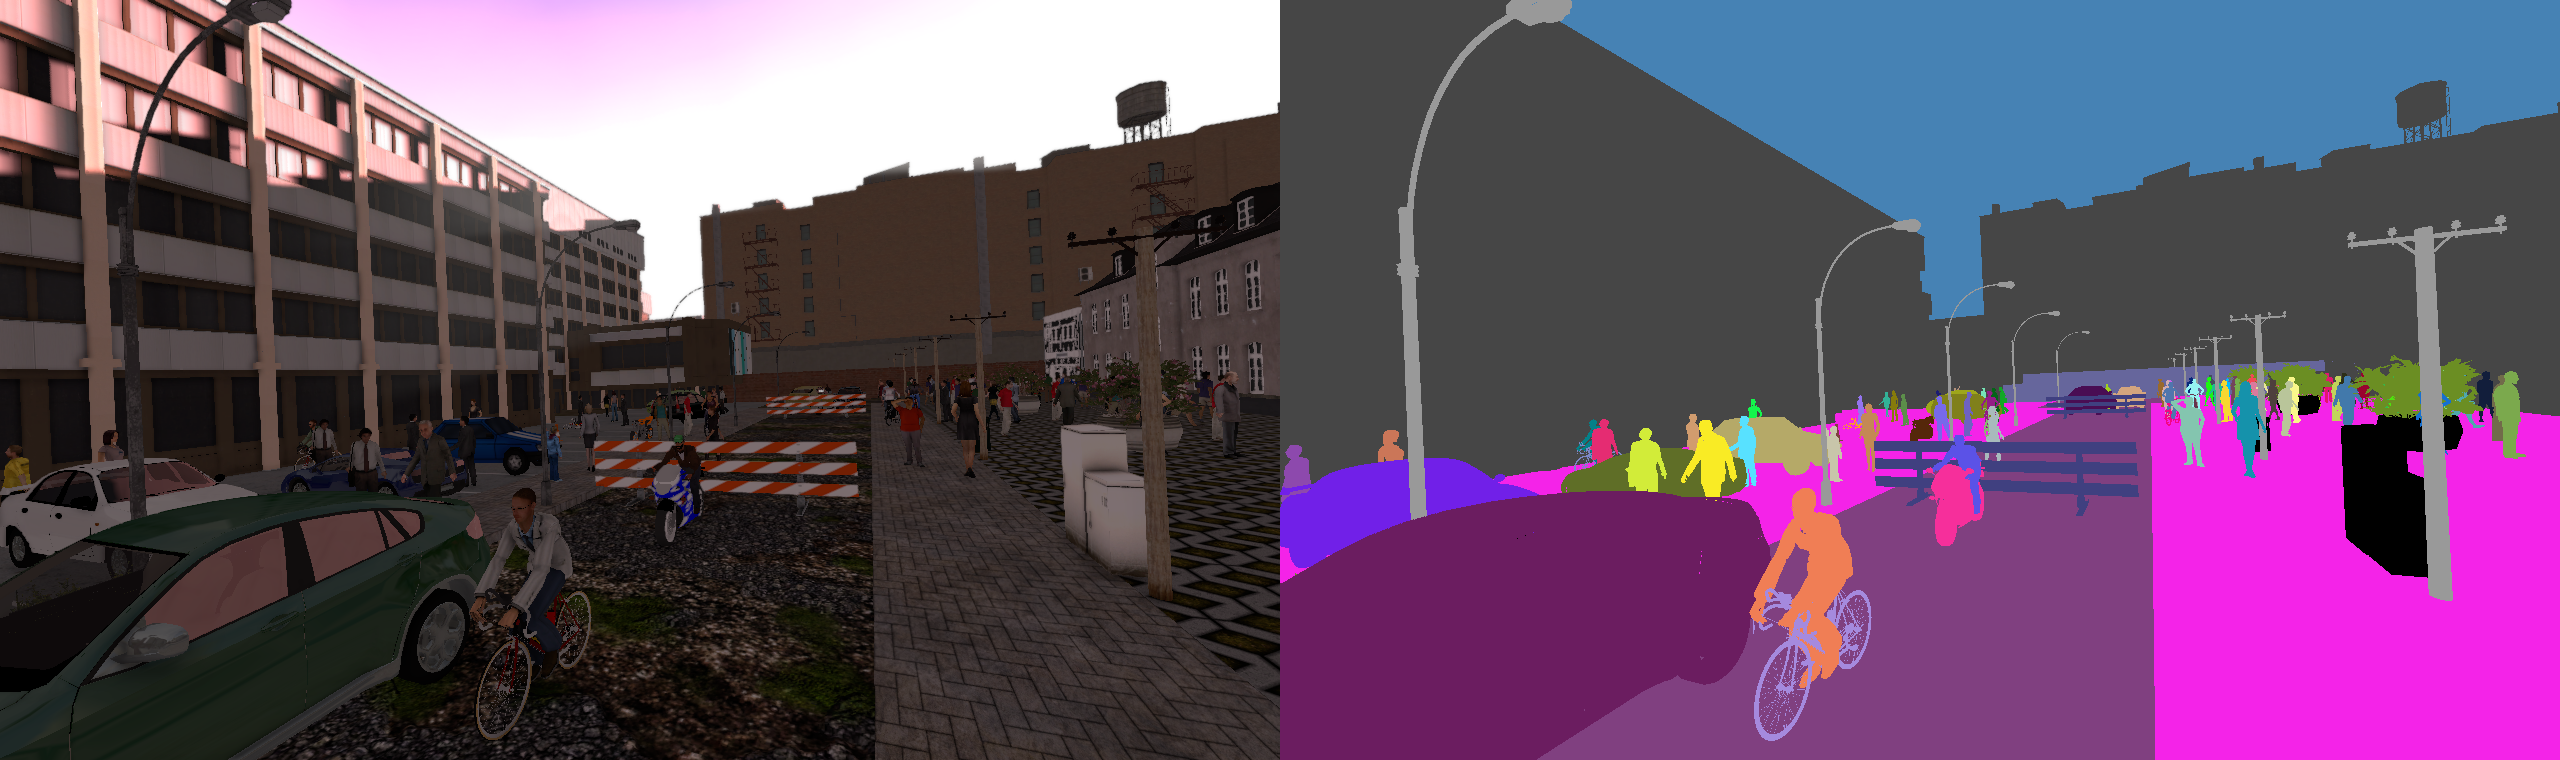

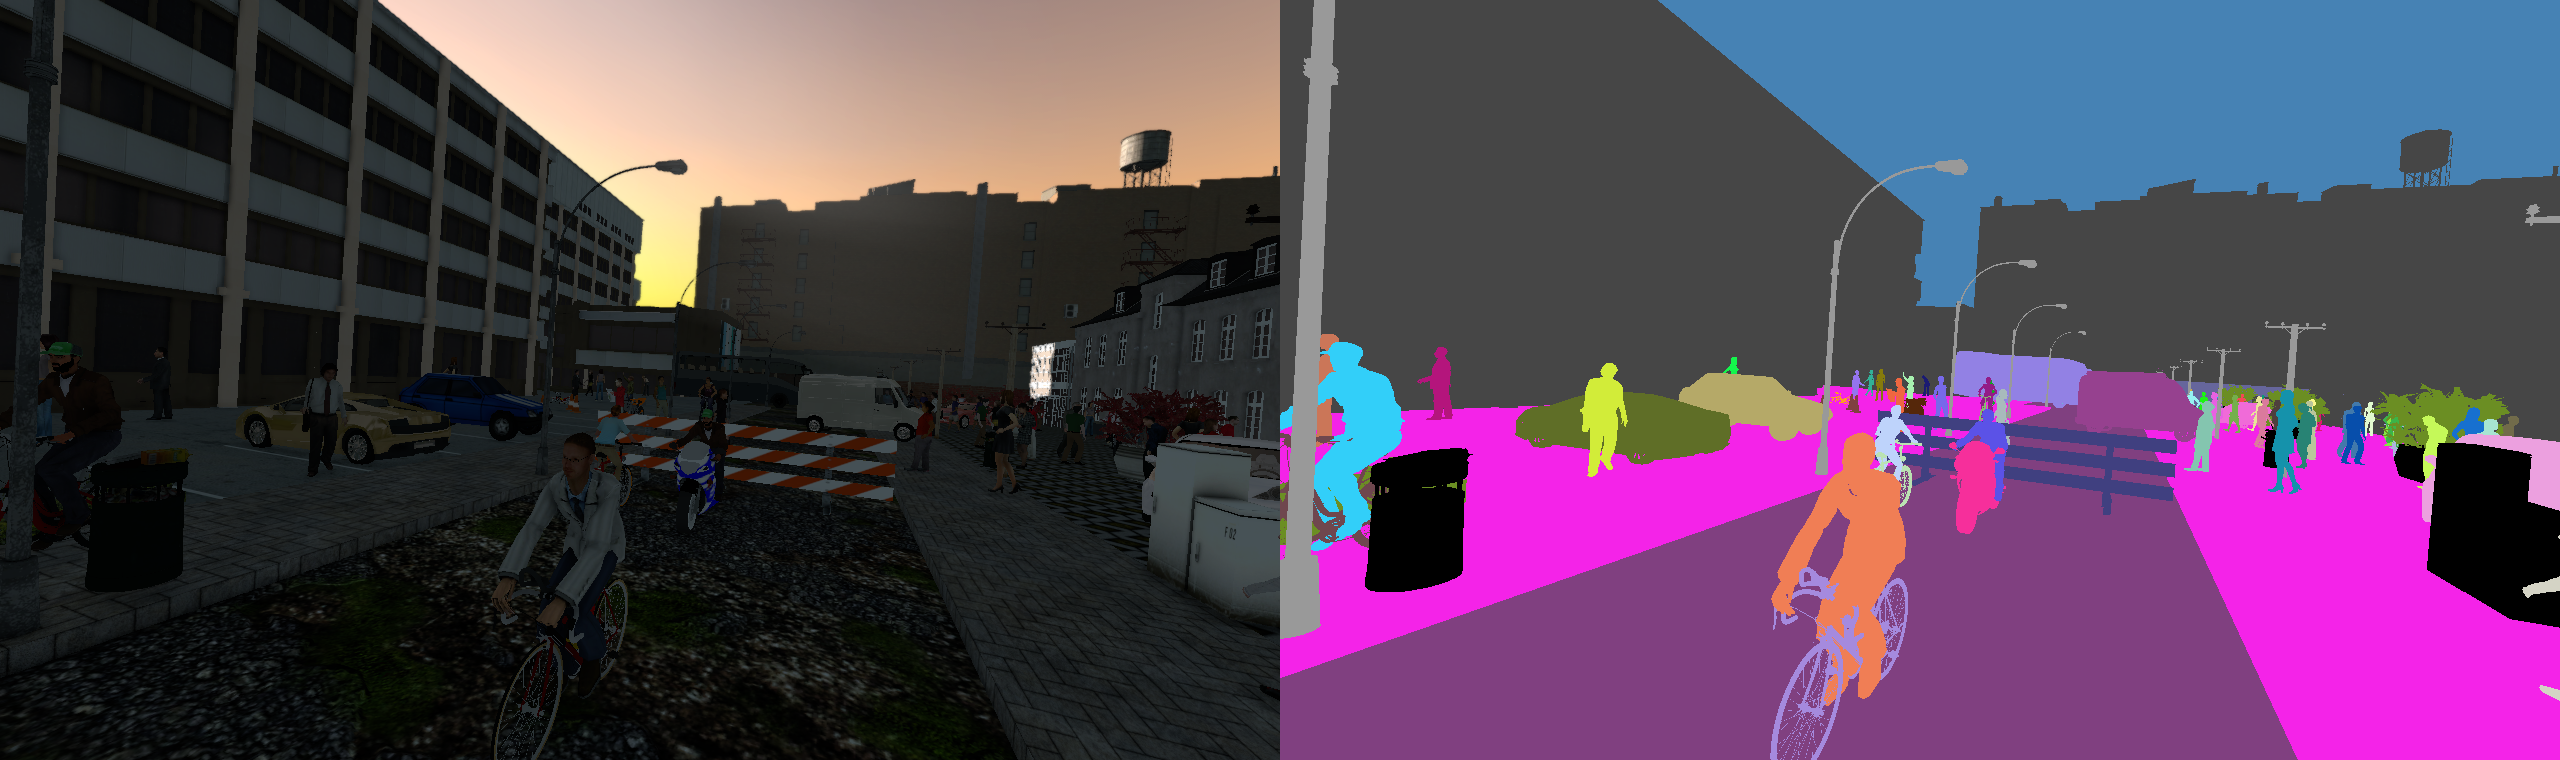

First two merged images from the validation folder:


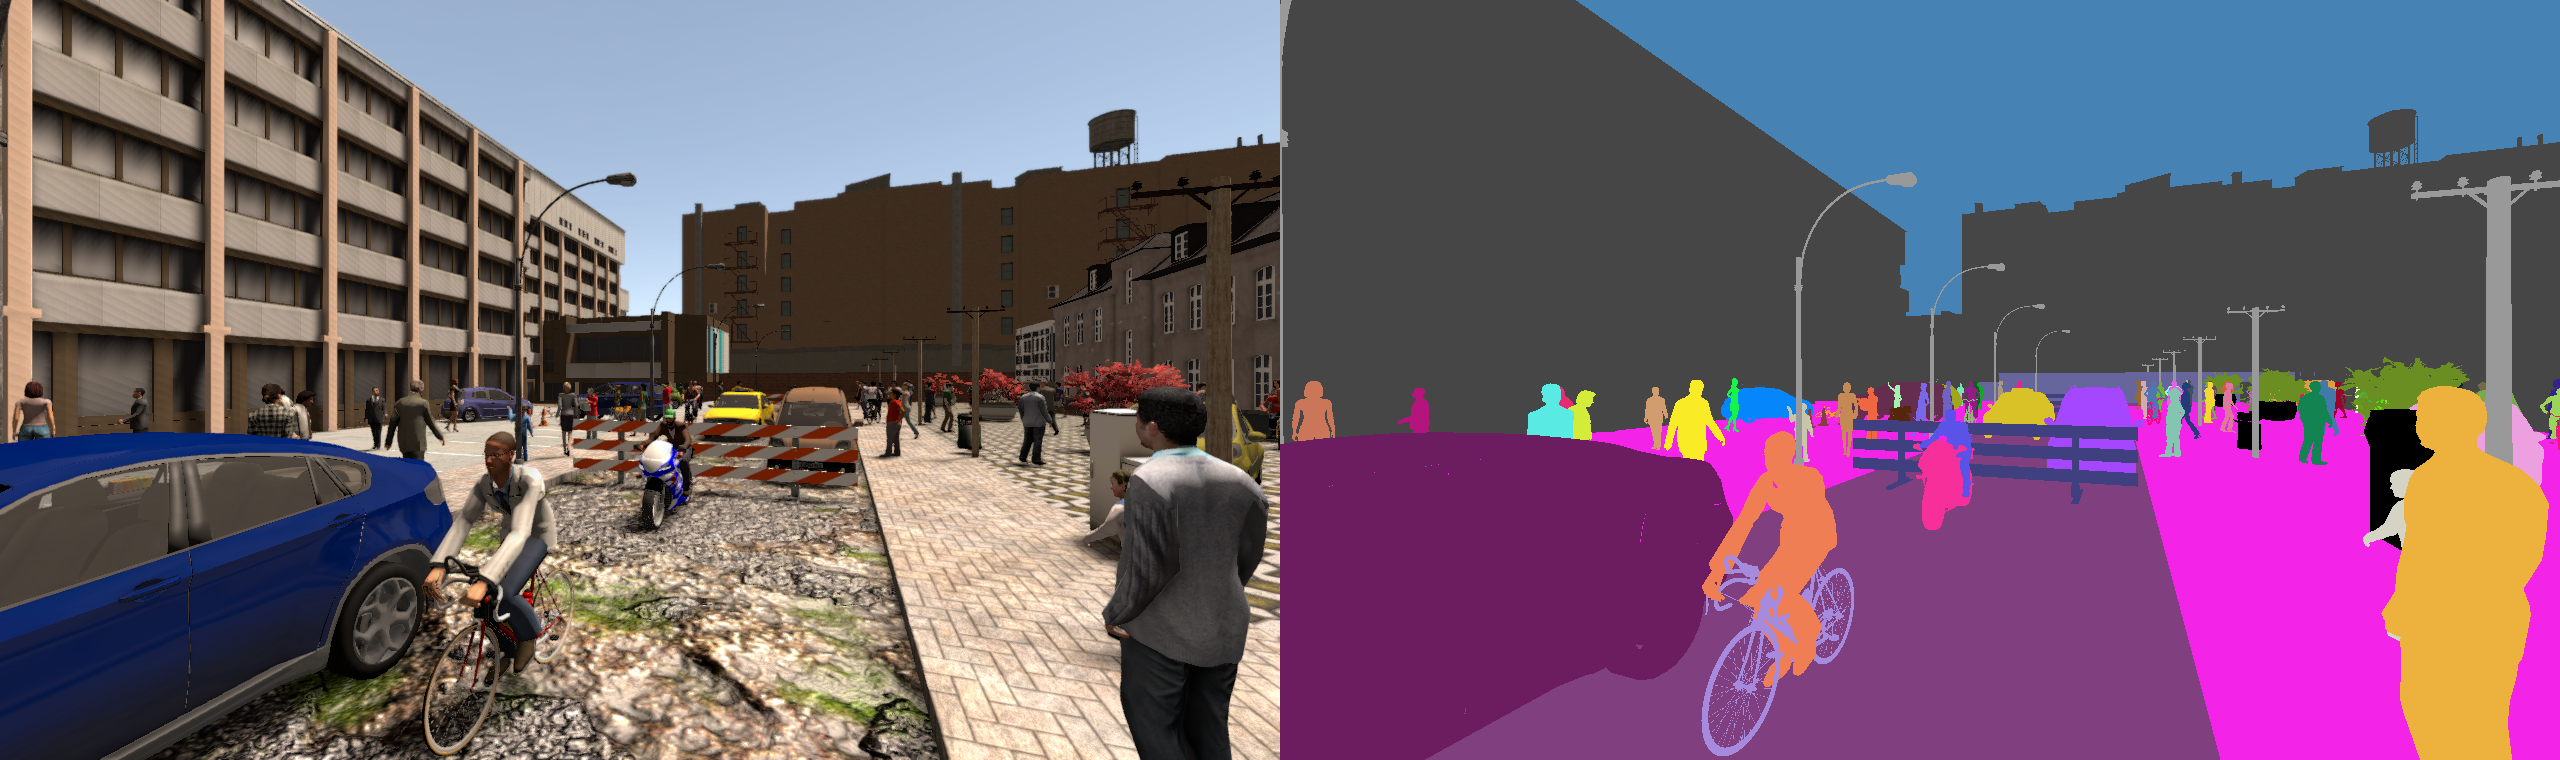

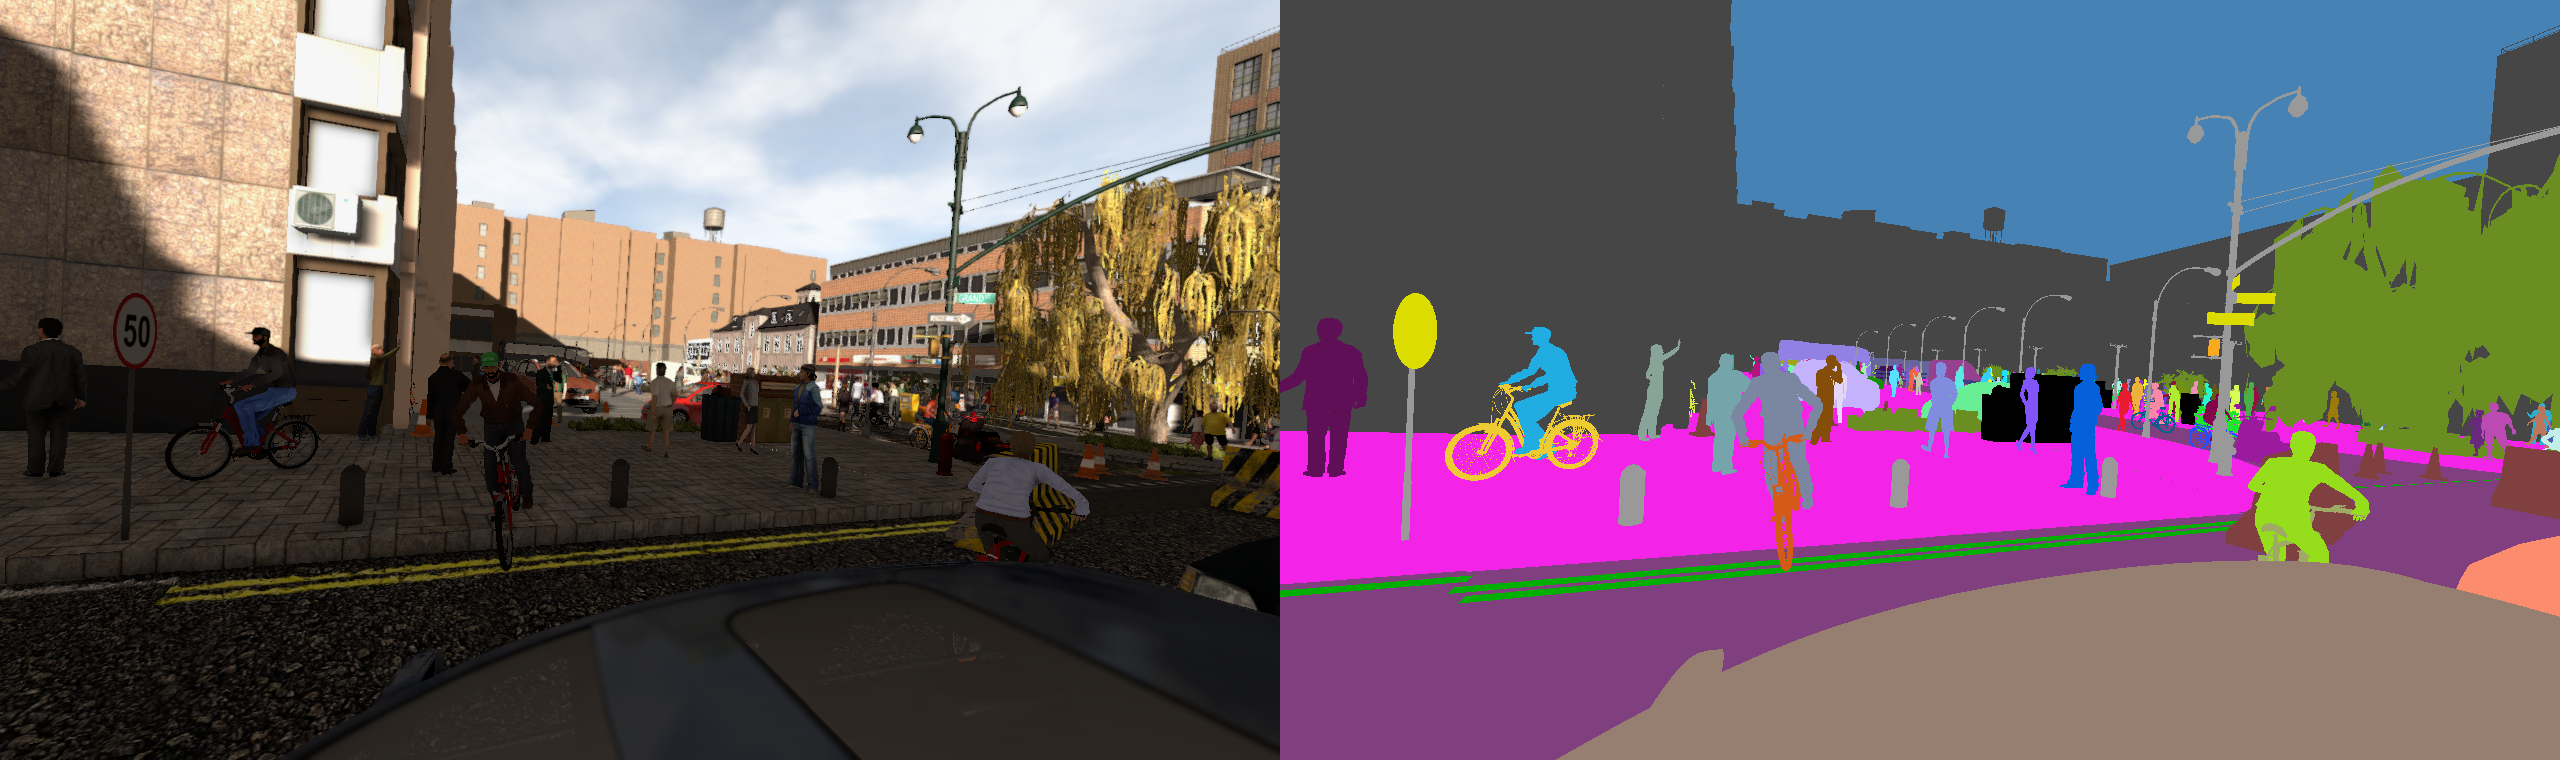

In [ ]:
# Function to display the first two merged images
def display_merged_images(folder):
    # Get a list of filenames in the folder
    filenames = os.listdir(folder)
    
    # Sort the filenames
    filenames.sort()
    
    # Iterate over the first two filenames
    for filename in filenames[:2]:
        # Get the path to the merged image
        image_path = os.path.join(folder, filename)
        
        # Open and display the image
        image = Image.open(image_path)
        image.show()
        image.close()

# Display the first two merged images from the train folder
print("First two merged images from the train folder:")
display_merged_images(train_folder)

# Display the first two merged images from the validation folder
print("First two merged images from the validation folder:")
display_merged_images(val_folder)



In [ ]:
import os
from PIL import Image

def resize_images(folder, width, height):
    # Get a list of filenames in the folder
    filenames = os.listdir(folder)
    
    # Iterate over the filenames
    for filename in filenames:
        # Get the path to the image
        image_path = os.path.join(folder, filename)
        
        # Open the image
        image = Image.open(image_path)
        
        # Resize the image
        resized_image = image.resize((width, height))
        
        # Save the resized image, overwriting the original image
        resized_image.save(image_path)
        
        # Close the image
        image.close()

# Resize images in the train folder
print("Resizing images in the train folder...")
resize_images(train_folder, 512, 256)

# Resize images in the val folder
print("Resizing images in the validation folder...")
resize_images(val_folder, 512, 256)

print("Image resizing complete!")

Resizing images in the train folder...
Resizing images in the validation folder...
Image resizing complete!


In [ ]:
# Function to display the size of images in a folder
def display_image_sizes(folder):
    # Get a list of filenames in the folder
    filenames = os.listdir(folder)
    
    # Sort the filenames
    filenames.sort()
    
    # Iterate over the filenames
    for filename in filenames:
        # Get the path to the image
        image_path = os.path.join(folder, filename)
        
        # Open the image and get its size
        image = Image.open(image_path)
        width, height = image.size
        
        # Print the filename, width, and height
        print(f"Image: {filename}, Width: {width}, Height: {height}")
        
        # Close the image
        image.close()

# Display the size of images in the train folder
print("Image sizes in the train folder:")
display_image_sizes(train_folder)

# Display the size of images in the validation folder
print("Image sizes in the validation folder:")
display_image_sizes(val_folder)

Image sizes in the train folder:
Image: image_1.png, Width: 512, Height: 256
Image: image_10.png, Width: 512, Height: 256
Image: image_100.png, Width: 512, Height: 256
Image: image_101.png, Width: 512, Height: 256
Image: image_104.png, Width: 512, Height: 256
Image: image_105.png, Width: 512, Height: 256
Image: image_106.png, Width: 512, Height: 256
Image: image_107.png, Width: 512, Height: 256
Image: image_108.png, Width: 512, Height: 256
Image: image_11.png, Width: 512, Height: 256
Image: image_110.png, Width: 512, Height: 256
Image: image_111.png, Width: 512, Height: 256
Image: image_113.png, Width: 512, Height: 256
Image: image_114.png, Width: 512, Height: 256
Image: image_115.png, Width: 512, Height: 256
Image: image_116.png, Width: 512, Height: 256
Image: image_117.png, Width: 512, Height: 256
Image: image_118.png, Width: 512, Height: 256
Image: image_119.png, Width: 512, Height: 256
Image: image_120.png, Width: 512, Height: 256
Image: image_121.png, Width: 512, Height: 256
Image

## Preprocessing the training and testing set

##Generator and other functions

In [ ]:
from PIL import Image
import numpy as np
import os

width = 256
height = 256
classes = 16
batch_size = 10
train_folder = "/content/drive/MyDrive/SelectedDatasets/Train"
val_folder = "/content/drive/MyDrive/SelectedDatasets/Val"

def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:, :width]
    mask = img[:, width:]
    
    return image, mask

def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, :, 0].astype(np.uint8)  # Convert to uint8
    img = Image.fromarray(img)  # Convert back to PIL Image
    img = img.resize((width, height), resample=Image.NEAREST)  # Resize the image
    
    for c in range(classes):
        seg_labels[:, :, c] = (np.array(img) == c).astype(int)
    return seg_labels

def DataGenerator(path, batch_size=10, classes=16):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs = []
            segs = []
            for file in batch_files:
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)
                
                image = resize_image(image, width, height)  # Resize image
                labels = resize_labels(labels, width, height)  # Resize labels

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

def resize_image(image, width, height):
    img = Image.fromarray(image)
    img = img.resize((width, height), resample=Image.NEAREST)
    return np.array(img)

def resize_labels(labels, width, height):
    resized_labels = []
    for c in range(classes):
        label = labels[:, :, c]
        label = Image.fromarray(label)
        label = label.resize((width, height), resample=Image.NEAREST)
        resized_labels.append(np.array(label))
    return np.stack(resized_labels, axis=2)

train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(val_folder, batch_size=batch_size)
imgs, segs = next(train_gen)
imgs.shape, segs.shape


((10, 256, 256, 3), (10, 256, 256, 16))

In [ ]:
def give_color_to_seg_img(seg, n_classes=13):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

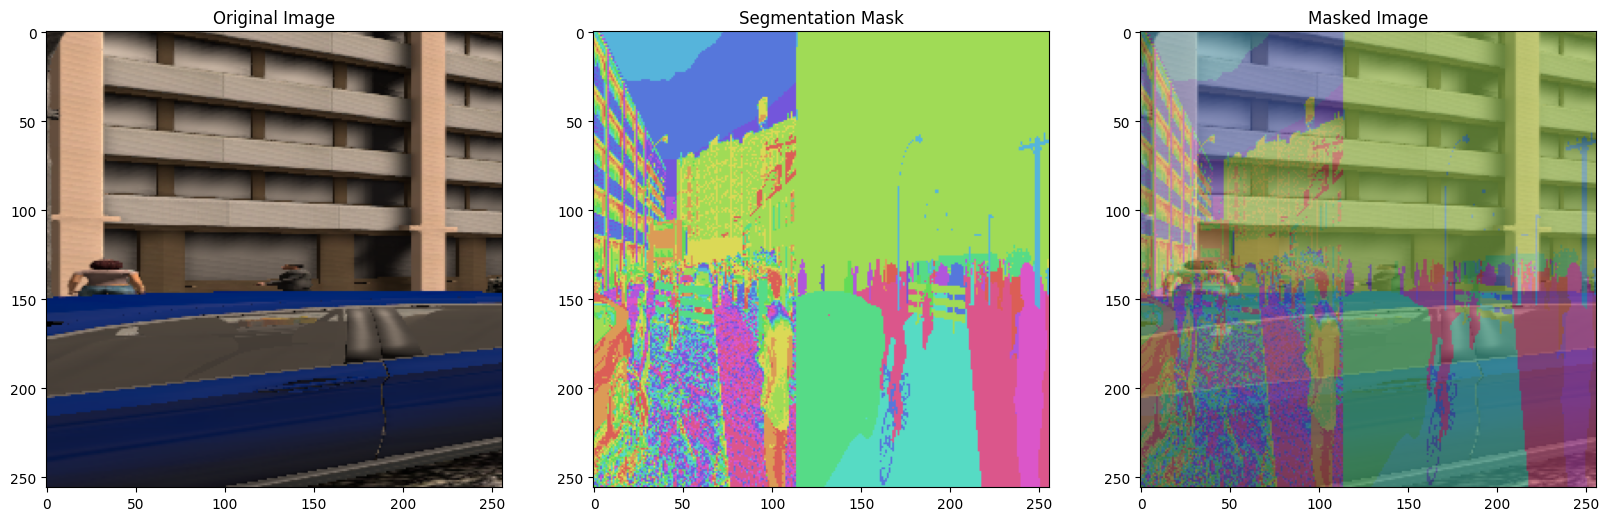

In [ ]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

##Training model

In [ ]:
def fcn(vgg, classes = 13, fcn8 = False, fcn16 = False):
    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(width, height, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model = fcn(vgg, fcn8=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "best-model-vgg.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(width, height, 3))
model = fcn(vgg, classes=classes, fcn8=False, fcn16=False)

adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

filepath = "best-model-vgg.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
                       callbacks=callbacks_list, use_multiprocessing=True)

<ipython-input-48-e34adbc86321>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,


Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 7.6143 - accuracy: 0.3188
Epoch 1: val_accuracy improved from -inf to 0.33871, saving model to best-model-vgg.hdf5
65/65 [==============================] - 232s 3s/step - loss: 7.6143 - accuracy: 0.3188 - val_loss: 1.9430 - val_accuracy: 0.3387
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 1.8390 - accuracy: 0.3634
Epoch 2: val_accuracy improved from 0.33871 to 0.34357, saving model to best-model-vgg.hdf5
65/65 [==============================] - 156s 2s/step - loss: 1.8390 - accuracy: 0.3634 - val_loss: 1.8862 - val_accuracy: 0.3436
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 1.7811 - accuracy: 0.3709
Epoch 3: val_accuracy improved from 0.34357 to 0.35062, saving model to best-model-vgg.hdf5
65/65 [==============================] - 165s 3s/step - loss: 1.7811 - accuracy: 0.3709 - val_loss: 1.8218 - val_accuracy: 0.3506
Epoch 4/10
65/65 [==============================] - ETA

In [ ]:
import pickle

# Save the history object to a file
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

import pickle

In [ ]:
# Load the history object from the file
with open('history.pkl', 'rb') as file:
    history = pickle.load(file)

# Access the training and validation metrics
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']


In [ ]:
# After training the model
model.save_weights("model_weights.h5")


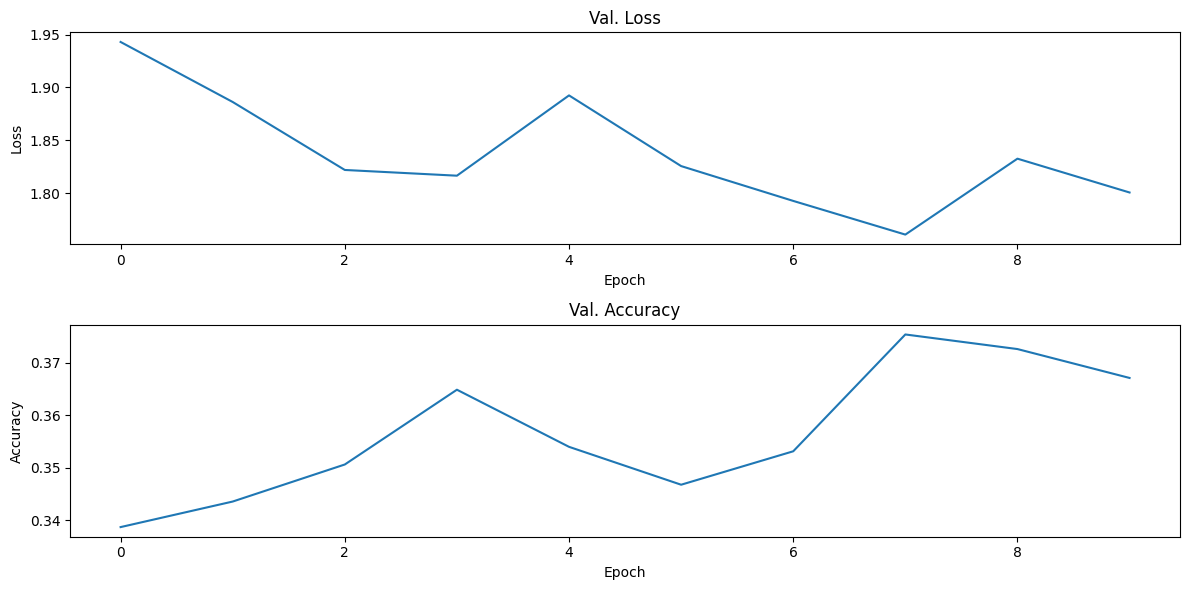

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(val_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig("learn.png", dpi=150)
plt.show()


In [ ]:
model.load_weights("best-model-vgg.hdf5")

1/1 [==============================] - 0s 205ms/step


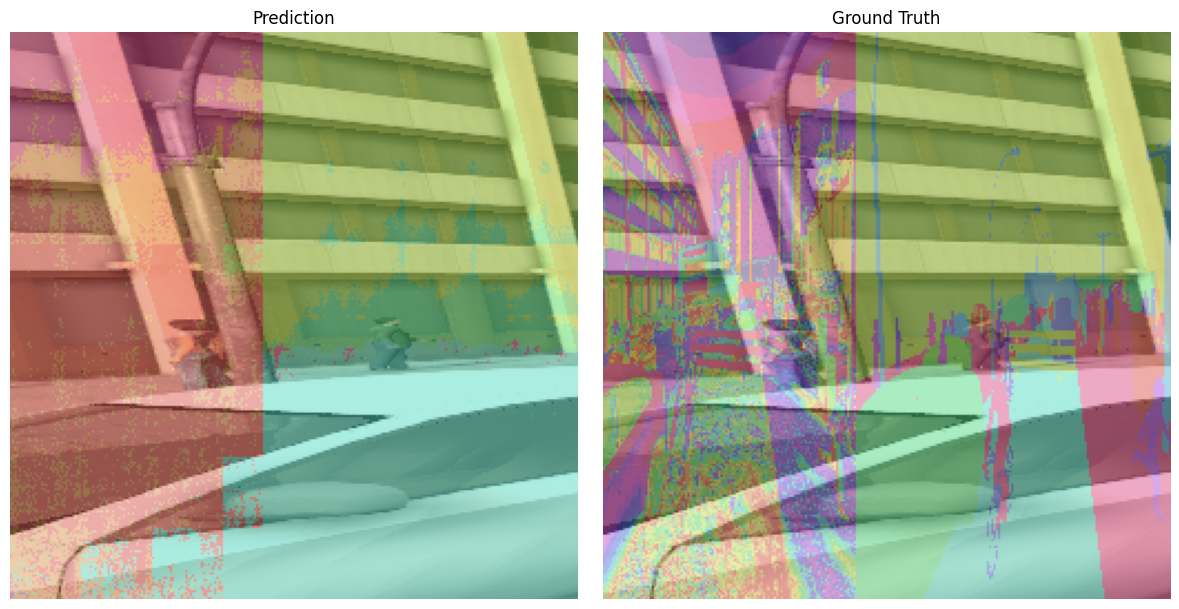

In [ ]:
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    
    plt.subplot(122)
    plt.title("Ground Truth")
    plt.imshow(trueimg)
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig("pred_{}.png".format(i), dpi=150)
    plt.show()


In [ ]:
import shutil

source_path = "/content/best-model-vgg.hdf5"
destination_path = "/content/drive/MyDrive/ParametersDeepLearning/Notebook2/best-model-vgg.hdf5"

shutil.copyfile(source_path, destination_path)


'/content/drive/MyDrive/ParametersDeepLearning/Notebook2/best-model-vgg.hdf5'

In [ ]:
import shutil

source_path = "/content/pred_0.png"
destination_path = "/content/drive/MyDrive/ParametersDeepLearning/Notebook2/pred_0.png"

shutil.copyfile(source_path, destination_path)


'/content/drive/MyDrive/ParametersDeepLearning/Notebook2/pred_0.png'